In [1]:
import pandas as pd
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import netCDF4

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

import optuna

import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [5]:
#temperature
file2read = netCDF4.Dataset('D:/Kpt/t2.nc4','r')

t2=np.array(file2read.variables['t2m']) 

In [20]:
#dewpoint
file2read = netCDF4.Dataset('D:/Kpt/td.nc4','r')

dt = np.array(file2read.variables['d2m']) 

In [17]:
file2read = netCDF4.Dataset('D:/Kpt/tp.nc4','r')

tp=np.array(file2read.variables['tp']) 

In [101]:
#localisation
#as a first step consider 3,5 closest to Norilsk lat = 69.25, lon = 88.25
latitude = np.array(file2read.variables['latitude'])
longitude = np.array(file2read.variables['longitude'])

print('longitude ',longitude)
print('latitude ',latitude)

longitude  [87.   87.25 87.5  87.75 88.   88.25 88.5  88.75 89.  ]
latitude  [70.   69.75 69.5  69.25 69.   68.75 68.5  68.25 68.  ]


In [19]:
tp.shape

(1, 8402, 1, 1, 9, 9)

In [21]:
dt.shape

(1, 8402, 1, 1, 9, 9)

In [22]:
t2.shape

(1, 8402, 1, 1, 9, 9)

In [29]:
file2read.variables['time'][0]

masked_array(data=946728000,
             mask=False,
       fill_value=999999,
            dtype=int64)

In [285]:
from datetime import date

datelist = pd.date_range(start="2000-01-01",end="2023-01-01")
month = pd.DataFrame([x.month for x in datelist])
num = month[month.isin([4,5,6,7,8,9])].index

In [295]:
condition = month.isin([4,5,6,7,8,9])
num=condition[condition[0]==1].index

In [276]:
#extract whole timeseries from cell3,5 for months warm_season

precipitation = tp[0, month.isin([4,5,6,7,8,9]), 0, 3, 5]*24000 #24 hours 1000 mm in 1 metre
temperature = t2[0, month.isin([4,5,6,7,8,9]), 0, 3, 5]
dewpoint = dt[0, month.isin([4,5,6,7,8,9]), 0, 3, 5]

days_number = len(precipitation)

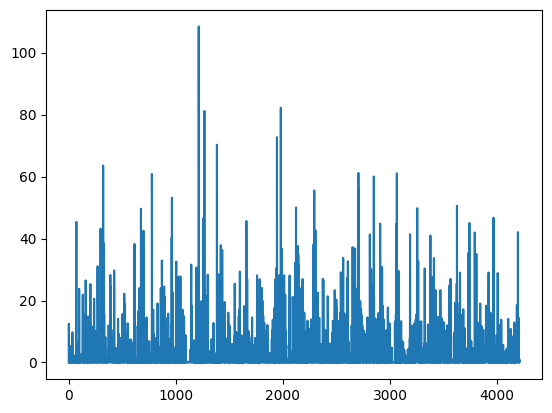

In [103]:
plt.plot(precipitation)

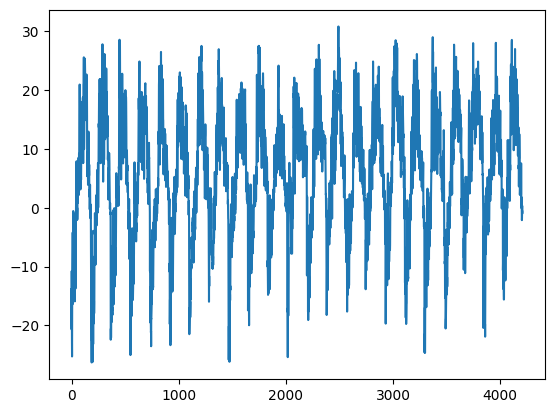

In [104]:
plt.plot(temperature-273)

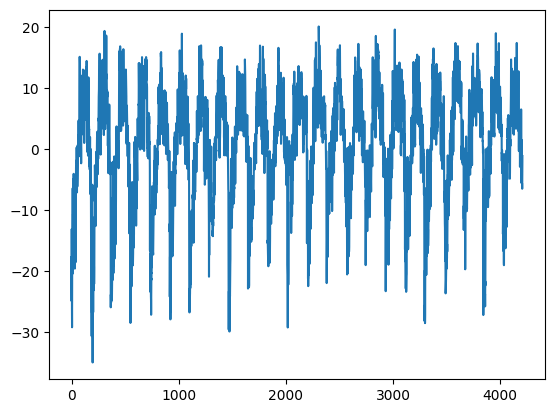

In [105]:
plt.plot(dewpoint-273)

### Nesterov index calculation

In [164]:
#Nesterov index calculation

days_after_rain = precipitation

for i in range(days_number):
    if precipitation[i] > 0.2:
        days_after_rain[i] = 0
    else:
        if i>0:
            days_after_rain[i] = days_after_rain[i-1] + 1
        else:
            days_after_rain[0] = 0
            
days_after_rain =list(days_after_rain.astype('int'))

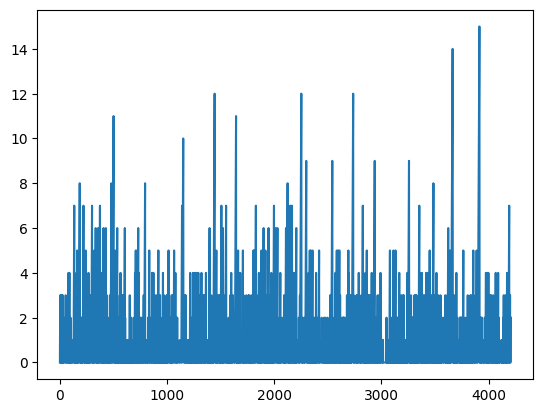

In [165]:
plt.plot(days_after_rain)

In [166]:
# temperature deficit
deficit = temperature - dewpoint

In [178]:
# Nesterov index calculation
nesterov_index = precipitation # initialisation
for i in range(len(precipitation)):
    sum = 0
    for j in range(days_after_rain[i]):
        sum = sum + (temperature[i-j] - 273)*deficit[i-j]
    nesterov_index[i] = sum

(array([2.00e+00, 1.00e+00, 1.00e+01, 1.30e+01, 5.40e+01, 2.28e+02,
        3.19e+03, 3.38e+02, 1.78e+02, 7.40e+01, 4.70e+01, 2.70e+01,
        1.50e+01, 1.30e+01, 7.00e+00, 5.00e+00, 6.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00]),
 array([-413.96173096, -348.0619812 , -282.16223145, -216.26249695,
        -150.36274719,  -84.46299744,  -18.5632515 ,   47.33649445,
         113.2362442 ,  179.13598633,  245.03573608,  310.93548584,
         376.8352356 ,  442.73498535,  508.63473511,  574.53448486,
         640.4342041 ,  706.33398438,  772.23370361,  838.13348389,
         904.03320312]),
 <BarContainer object of 20 artists>)

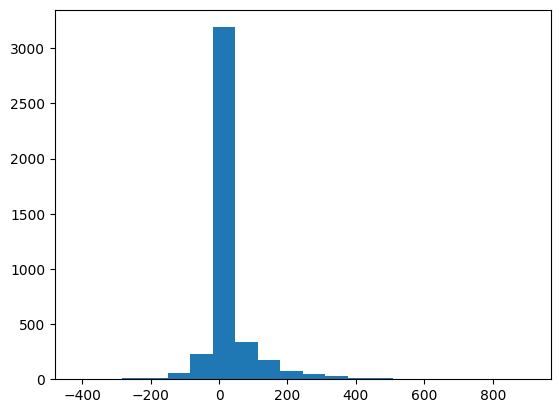

In [182]:
plt.hist(nesterov_index, bins=20)

### Import fires files

In [142]:
fires_M = pd.read_csv('D:/Kpt/fires_MODIS.csv',
                        sep=',',
                        skip_blank_lines=True 
                        #,names=['date','time','ppb']
                      )# parse_dates=[0,1]

In [143]:
display(fires_M)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,69.3681,88.1128,310.7,1.1,1.0,2001-05-09,1535,Terra,MODIS,72,6.03,267.0,17.8,N,2
1,69.3674,88.1255,322.6,1.2,1.1,2001-05-23,1547,Terra,MODIS,100,6.03,268.1,32.5,N,2
2,69.3737,88.0945,303.3,2.2,1.4,2001-06-08,742,Terra,MODIS,52,6.03,275.9,24.1,D,2
3,69.3597,88.1351,305.4,2.2,1.5,2001-06-08,742,Terra,MODIS,61,6.03,278.3,27.0,D,2
4,69.3093,88.2542,307.4,1.9,1.3,2001-06-09,509,Terra,MODIS,50,6.03,286.4,20.7,D,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4509,69.3669,88.0956,324.7,1.5,1.2,2022-09-20,1358,Terra,MODIS,100,6.03,269.8,53.8,N,2
4510,69.3752,88.1272,326.3,1.5,1.2,2022-09-20,1358,Terra,MODIS,100,6.03,270.6,57.0,N,2
4511,69.3684,88.1217,311.5,1.8,1.3,2022-09-25,1554,Terra,MODIS,83,6.03,268.6,38.7,N,2
4512,69.3691,88.1216,304.3,1.0,1.0,2022-09-28,1446,Terra,MODIS,59,6.03,270.1,12.0,N,2


(array([ 58., 140., 178., 269., 266., 294., 285., 369., 388., 416., 426.,
        416., 360., 240., 186., 126.,  61.,  30.,   4.,   2.]),
 array([264.9  , 267.255, 269.61 , 271.965, 274.32 , 276.675, 279.03 ,
        281.385, 283.74 , 286.095, 288.45 , 290.805, 293.16 , 295.515,
        297.87 , 300.225, 302.58 , 304.935, 307.29 , 309.645, 312.   ]),
 <BarContainer object of 20 artists>)

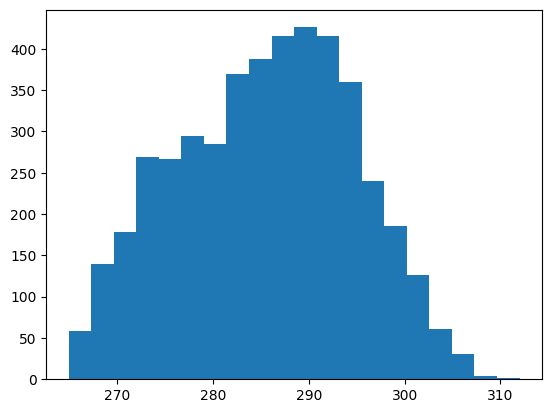

In [144]:
plt.hist(fires_M[['bright_t31']],bins=20)

(array([3.069e+03, 1.154e+03, 2.240e+02, 4.200e+01, 1.000e+01, 4.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.  ,  28.16,  56.32,  84.48, 112.64, 140.8 , 168.96, 197.12,
        225.28, 253.44, 281.6 , 309.76, 337.92, 366.08, 394.24, 422.4 ,
        450.56, 478.72, 506.88, 535.04, 563.2 ]),
 <BarContainer object of 20 artists>)

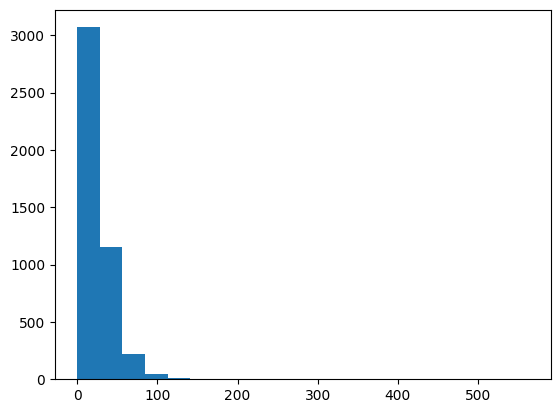

In [145]:
plt.hist(fires_M[['frp']],bins=20)

(array([ 60.,   3.,  18.,  29.,  52.,  77., 115., 163., 234., 308., 385.,
        462., 479., 500., 404., 306., 201., 190., 123., 405.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

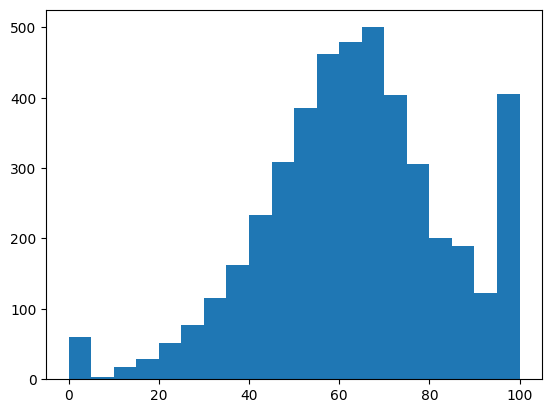

In [146]:
plt.hist(fires_M[['confidence']],bins=20)

#### Extract points inside ERA5 pixel 3,5

In [206]:
fires = fires_M.loc[
     (fires_M['longitude']>=(longitude[5]-0.125)) & 
     (fires_M['longitude']<(longitude[5]+0.125)) &
     (fires_M['latitude']>=(latitude[3]-0.125)) &
     (fires_M['latitude']<(latitude[3]+0.125))
         ]

display(pd.DataFrame(fires))
print(fires.info())

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
1,69.3674,88.1255,322.6,1.2,1.1,2001-05-23,1547,Terra,MODIS,100,6.03,268.1,32.5,N,2
3,69.3597,88.1351,305.4,2.2,1.5,2001-06-08,742,Terra,MODIS,61,6.03,278.3,27.0,D,2
4,69.3093,88.2542,307.4,1.9,1.3,2001-06-09,509,Terra,MODIS,50,6.03,286.4,20.7,D,2
5,69.3119,88.2060,301.8,1.9,1.3,2001-06-09,509,Terra,MODIS,23,6.03,287.9,11.4,D,2
6,69.3720,88.1256,303.2,2.2,1.4,2001-06-09,1630,Terra,MODIS,54,6.03,278.2,30.0,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,69.3743,88.1382,315.7,1.0,1.0,2022-08-26,2104,Aqua,MODIS,92,6.03,275.0,19.8,N,2
4493,69.3682,88.1332,307.2,1.7,1.3,2022-08-28,1352,Terra,MODIS,70,6.03,273.9,25.7,N,2
4494,69.3716,88.1351,307.0,1.4,1.2,2022-09-01,703,Aqua,MODIS,65,6.03,278.1,17.6,D,2
4498,69.3743,88.1259,317.8,1.0,1.0,2022-09-01,1506,Terra,MODIS,96,6.03,279.0,20.6,N,2


<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 1 to 4513
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    2204 non-null   float64
 1   longitude   2204 non-null   float64
 2   brightness  2204 non-null   float64
 3   scan        2204 non-null   float64
 4   track       2204 non-null   float64
 5   acq_date    2204 non-null   object 
 6   acq_time    2204 non-null   int64  
 7   satellite   2204 non-null   object 
 8   instrument  2204 non-null   object 
 9   confidence  2204 non-null   int64  
 10  version     2204 non-null   float64
 11  bright_t31  2204 non-null   float64
 12  frp         2204 non-null   float64
 13  daynight    2204 non-null   object 
 14  type        2204 non-null   int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 275.5+ KB
None


In [332]:
fires_groupped = fires[['confidence','frp','bright_t31','acq_date']].groupby('acq_date').mean()
display(fires_groupped)
fires_target =dates.merge(fires_groupped, right_index=True, left_on=0, how="left")
fires_target = fires_target.fillna(0)

display(fires_target)

,confidence,frp,bright_t31
acq_date,,,
2001-05-23,100.000000,32.500000,268.100000
2001-06-08,61.000000,27.000000,278.300000
2001-06-09,42.333333,20.700000,284.166667
2001-06-10,62.000000,12.000000,281.400000
2001-06-11,43.333333,25.066667,282.800000
...,...,...,...
2022-08-20,52.000000,11.400000,275.900000
2022-08-26,92.000000,19.800000,275.000000
2022-08-28,70.000000,25.700000,273.900000


,0,confidence,frp,bright_t31
0,NaT,0.0,0.0,0.0
1,NaT,0.0,0.0,0.0
2,NaT,0.0,0.0,0.0
3,NaT,0.0,0.0,0.0
4,NaT,0.0,0.0,0.0
...,...,...,...,...
8397,NaT,0.0,0.0,0.0
8398,NaT,0.0,0.0,0.0
8399,NaT,0.0,0.0,0.0
8400,NaT,0.0,0.0,0.0


In [333]:
fires_target = fires_target.iloc[num]

# Create features and target

In [330]:
features = pd.DataFrame(precipitation)
features['precipitation'] = precipitation
features = features.drop(0, axis=1)
features['temperature'] = temperature
features['dewpoint'] = dewpoint
features['nesterov_index'] = nesterov_index

In [331]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   precipitation   4209 non-null   float32
 1   temperature     4209 non-null   float32
 2   dewpoint        4209 non-null   float32
 3   nesterov_index  4209 non-null   float32
dtypes: float32(4)
memory usage: 65.9 KB


In [334]:
target = fires_target['confidence']
target.info()

<class 'pandas.core.series.Series'>
Index: 4209 entries, 91 to 8308
Series name: confidence
Non-Null Count  Dtype  
--------------  -----  
4209 non-null   float64
dtypes: float64(1)
memory usage: 65.8 KB


### Modelling

In [335]:
# split into train and target
# take first 2000 observations as train
# other 386 as test

feat_train = features.iloc[:3000,]
feat_test = features.iloc[3000:,]
target_train = target.iloc[:3000,]
target_test = target.iloc[3000:,]

In [336]:
# scale the train samples

scaler = StandardScaler()
scaler.fit(feat_train)
feat_train_scaled = scaler.transform(feat_train)

In [337]:
#Optuna hyperparameter search for Random Forest

def objective(trial: optuna.Trial) -> float:
    param = {
         "max_depth": trial.suggest_int("max_depth", 1, 20),
         "criterion": trial.suggest_categorical("criterion",["squared_error", "absolute_error", "friedman_mse", "poisson"]),
         
         "n_estimators": trial.suggest_int("n_estimators",5, 100)
    }
    
    RF_model = RandomForestRegressor(**param)
    RF_model.fit(feat_train_scaled, 
                  target_train                 )
    
    preds = RF_model.predict(scaler.transform(feat_test))
    accuracy = -mean_absolute_error(target_test, preds)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
               n_trials=70              
              )

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-23 14:21:03,041] A new study created in memory with name: no-name-c91e0bf7-6cef-4639-8ef1-5500b5509616
[I 2024-05-23 14:21:03,499] Trial 0 finished with value: -19.516911429029125 and parameters: {'max_depth': 4, 'criterion': 'friedman_mse', 'n_estimators': 44}. Best is trial 0 with value: -19.516911429029125.
[I 2024-05-23 14:21:05,505] Trial 1 finished with value: -19.595352988097275 and parameters: {'max_depth': 14, 'criterion': 'poisson', 'n_estimators': 81}. Best is trial 0 with value: -19.516911429029125.
[I 2024-05-23 14:21:05,685] Trial 2 finished with value: -19.50323213591439 and parameters: {'max_depth': 7, 'criterion': 'poisson', 'n_estimators': 10}. Best is trial 2 with value: -19.50323213591439.
[I 2024-05-23 14:21:06,240] Trial 3 finished with value: -19.547629778381 and parameters: {'max_depth': 3, 'criterion': 'squared_error', 'n_estimators': 69}. Best is trial 2 with value: -19.50323213591439.
[I 2024-05-23 14:21:09,952] Trial 4 finished with value: -12.936

[I 2024-05-23 14:24:11,706] Trial 39 finished with value: -19.46381230596775 and parameters: {'max_depth': 5, 'criterion': 'poisson', 'n_estimators': 11}. Best is trial 30 with value: -11.822749353394515.
[I 2024-05-23 14:24:13,732] Trial 40 finished with value: -11.840296620941784 and parameters: {'max_depth': 2, 'criterion': 'absolute_error', 'n_estimators': 33}. Best is trial 30 with value: -11.822749353394515.
[I 2024-05-23 14:24:15,905] Trial 41 finished with value: -11.829889047630983 and parameters: {'max_depth': 2, 'criterion': 'absolute_error', 'n_estimators': 33}. Best is trial 30 with value: -11.822749353394515.
[I 2024-05-23 14:24:18,865] Trial 42 finished with value: -11.986798267443428 and parameters: {'max_depth': 3, 'criterion': 'absolute_error', 'n_estimators': 33}. Best is trial 30 with value: -11.822749353394515.
[I 2024-05-23 14:24:21,306] Trial 43 finished with value: -11.89343214454877 and parameters: {'max_depth': 2, 'criterion': 'absolute_error', 'n_estimators':

Number of finished trials: 70
Best trial:
  Value: -11.786121942573557
  Params: 
    max_depth: 1
    criterion: absolute_error
    n_estimators: 18


In [338]:
best_params_RF = trial.params


RF_model = RandomForestRegressor(**best_params_RF)
RF_model.fit(feat_train_scaled, 
                  target_train )
    
predictions_RF = RF_model.predict(scaler.transform(feat_test))


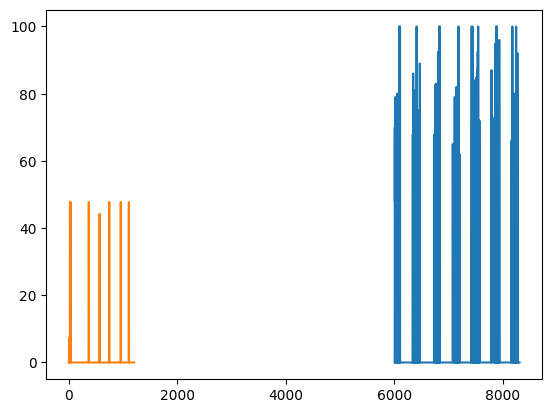

In [345]:
plt.plot(target_test)
plt.plot(predictions_RF)


(array([1.195e+03, 1.000e+00, 0.000e+00, 0.000e+00, 1.100e+01, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.54353261, 1.08706522, 1.63059783, 2.17413043,
        2.71766304, 3.26119565, 3.80472826, 4.34826087, 4.89179348,
        5.43532609]),
 <BarContainer object of 10 artists>)

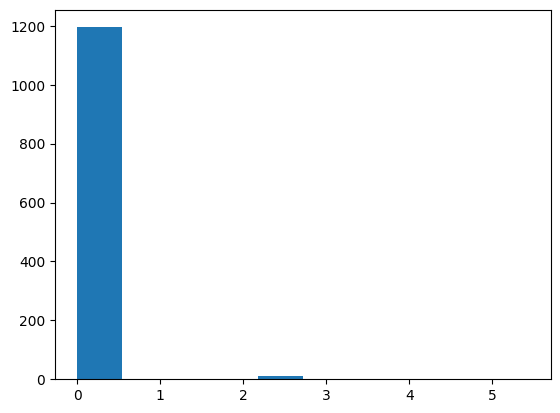

In [315]:
plt.hist(predictions_RF)